(160801, 2)
160801 beta values found in the mesh
2.250430177405076e-73 1.3680337686068025e-62


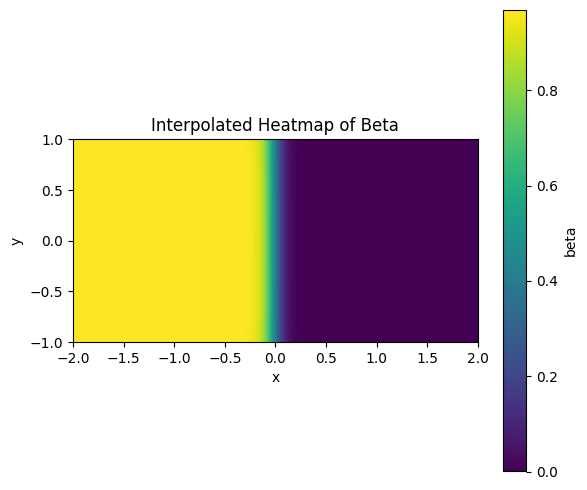

In [24]:
import pyvista as pv
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np

# Load the VTU file
mesh = pv.read("fem_sim.vtu")  # replace with actual path

points = mesh.points[:, :2]  # take x, y
print(points.shape)
beta = mesh.point_data["beta"]
print(len(beta), "beta values found in the mesh")

# Create a regular grid
num_points = 500  # resolution
x = np.linspace(points[:,0].min(), points[:,0].max(), num_points)
y = np.linspace(points[:,1].min(), points[:,1].max(), num_points)
X, Y = np.meshgrid(x, y)

beta = np.array(beta)
print(np.min(beta), np.max(beta))
beta /= np.std(beta)
beta = np.tanh(beta)
beta = list(beta)

# Interpolate onto the grid
Z = griddata(points, beta, (X, Y), method='linear')

# Plot as heatmap
plt.figure(figsize=(6,5))
plt.imshow(Z, extent=(x.min(), x.max(), y.min(), y.max()),
           origin='lower', cmap='viridis', aspect='equal')
plt.colorbar(label='beta')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Interpolated Heatmap of Beta')
plt.tight_layout()
plt.show()

Number of points in mesh: 160801
6.559998351308076e-05


/Users/yh_huang/venv/generic/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


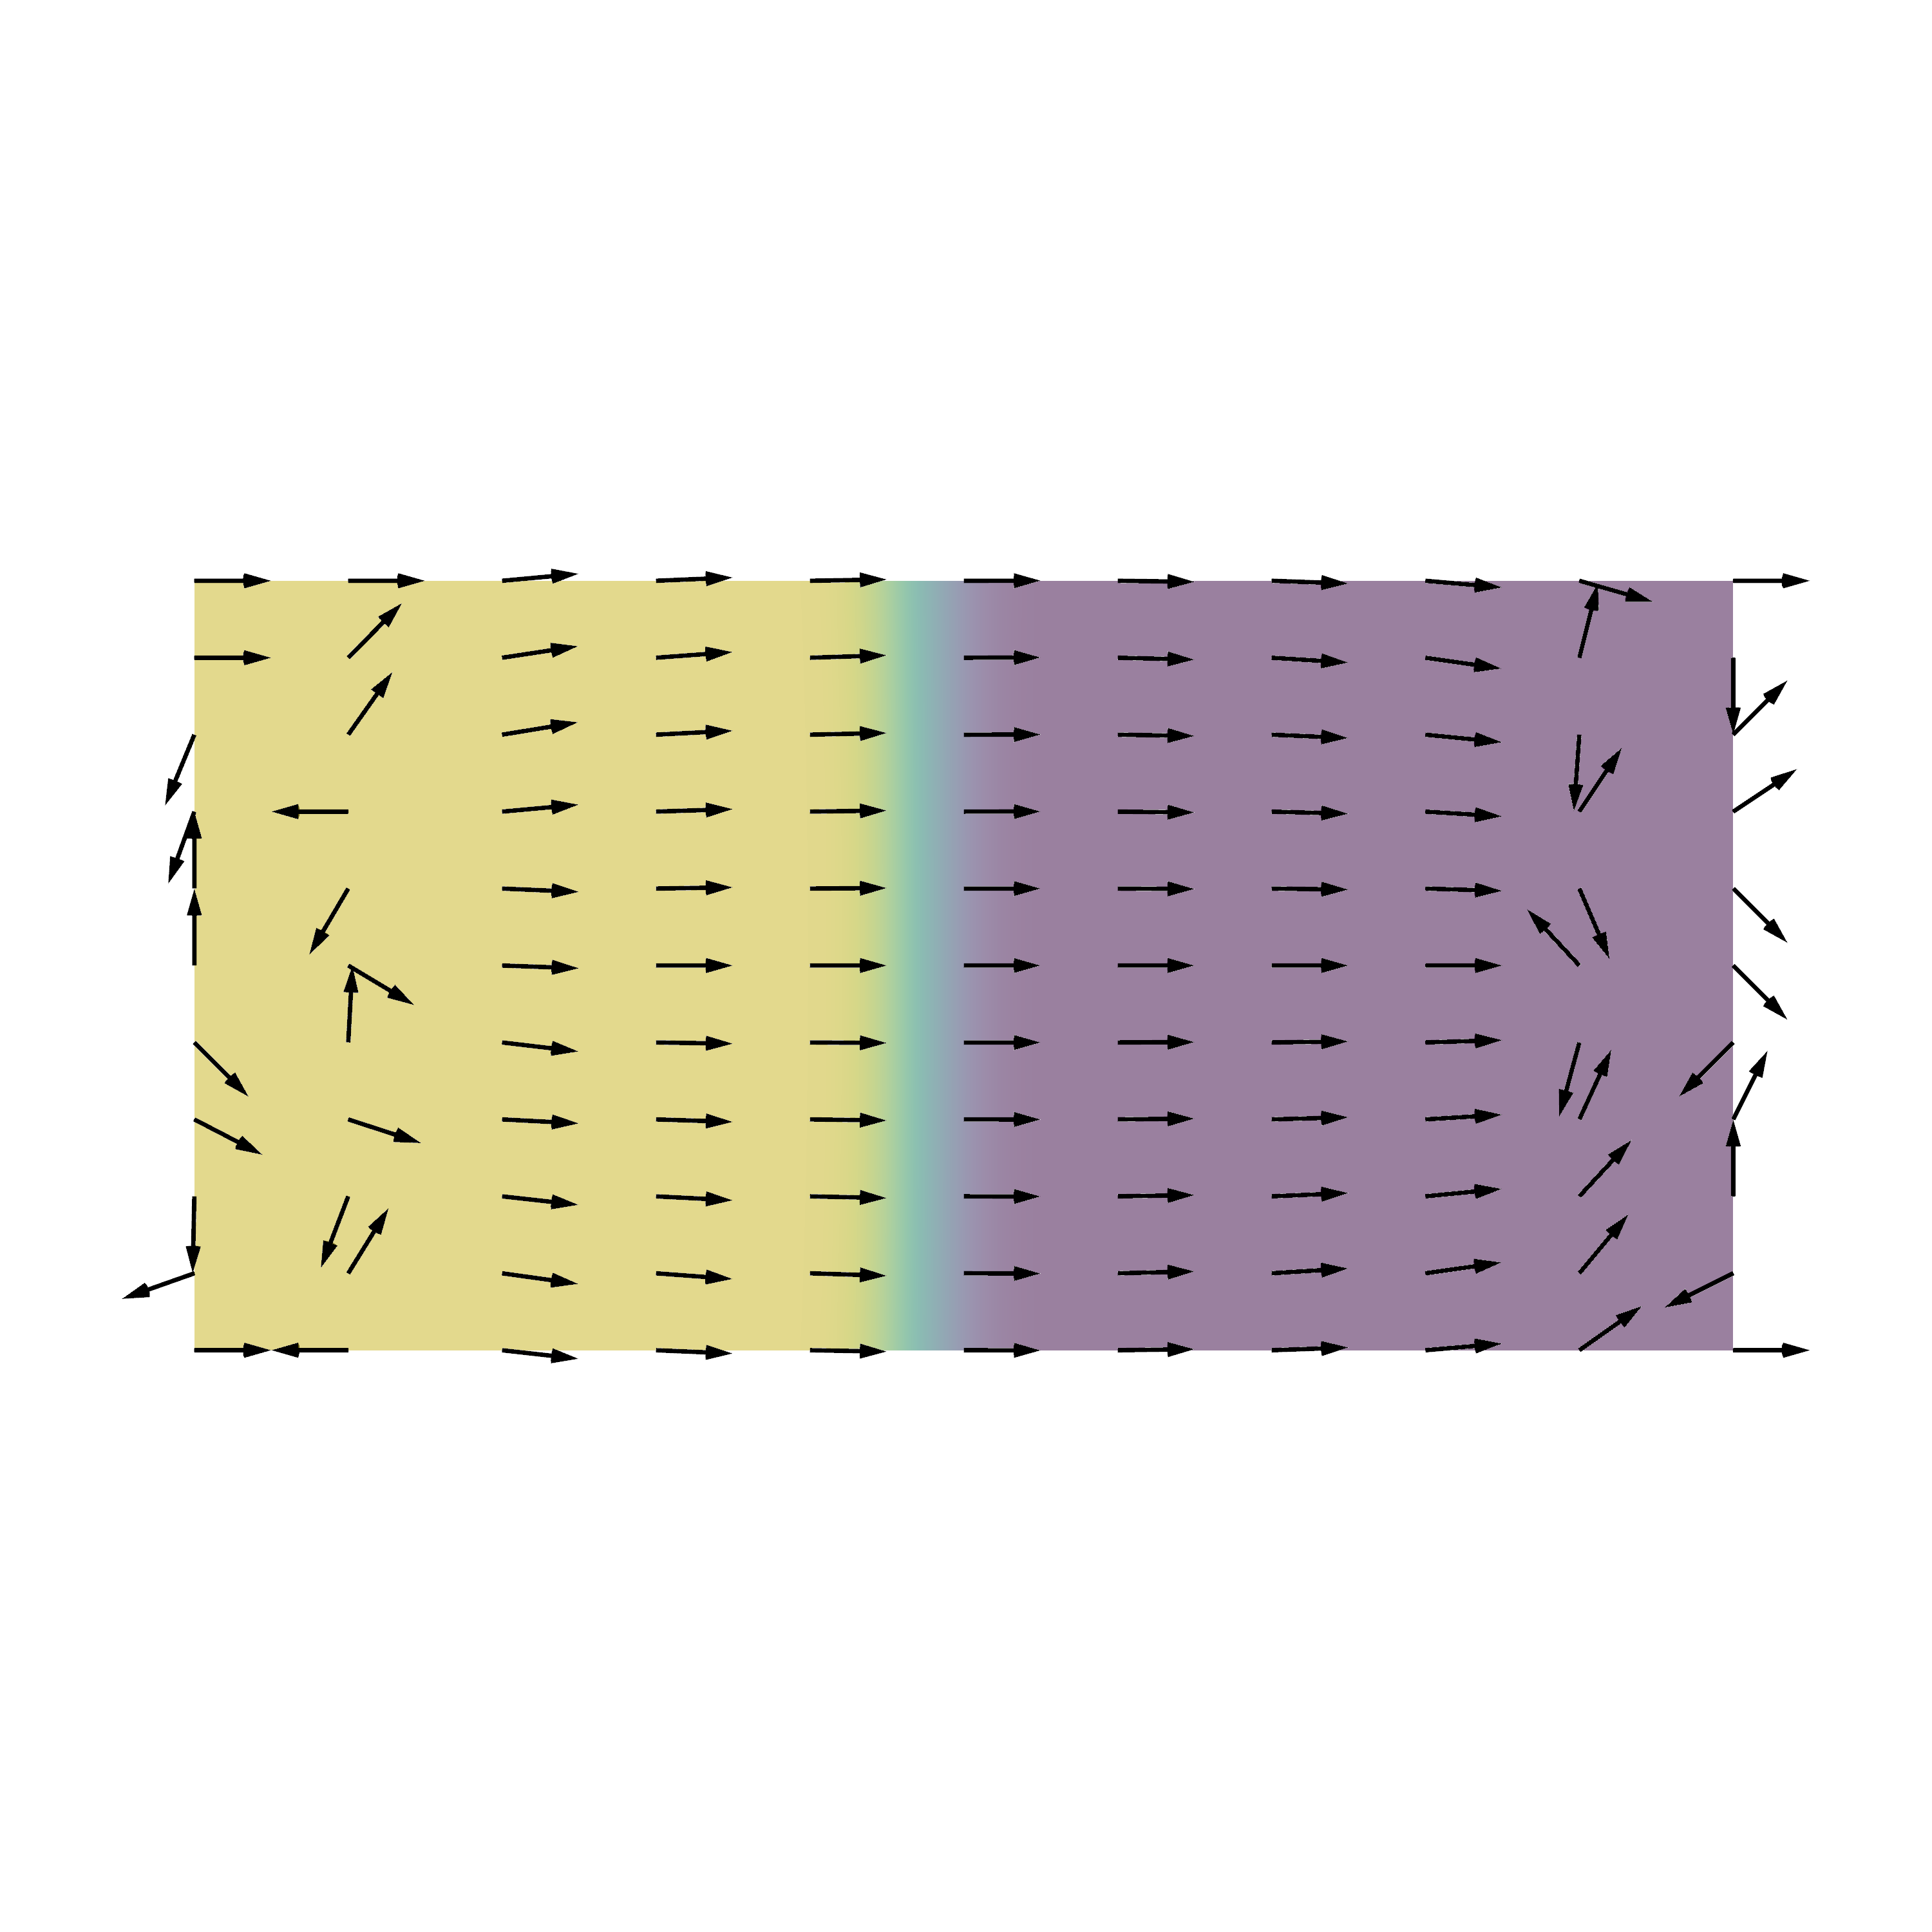

pyvista_ndarray([[[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 ...,

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
  

In [64]:
mesh = mesh.compute_derivative(scalars="beta", gradient=True)
# Optional: scale gradient by a function of position
# For example: scale by exp(V(x, y)/g^2)
points = mesh.points[:, :2]
x, y = points[:, 0], points[:, 1]

import numpy as np

def V(u, v, lambda_val, g_val, b_val):
    term1 = lambda_val * (np.cos(u) - np.cos(v)) - 2 * np.log(np.cos(u) + np.cos(v))
    term2 = 2 * g_val * b_val / np.sqrt(lambda_val) * np.log(np.cos(u) + np.cos(v))
    term3 = -2 * g_val * b_val / np.sqrt(lambda_val) * np.log(
        2 + 2 * np.sin((u + v) / 2) + 2 * np.sin((u - v) / 2) + np.cos(v) - np.cos(u)
    )
    return term1 + term2 + term3

g_val = 0.1
b_val = 0.5
lambda_val = 1.8
scale = -g_val**2 * np.exp(-V(x, y, lambda_val=lambda_val, g_val=g_val, b_val=b_val) / g_val**2)  # shape (N,)
scaled_grad = mesh["gradient"] * scale[:, np.newaxis]

# Add scaled gradient to mesh
mesh["scaled_gradient"] = scaled_grad

# Randomly select a subset of points
np.random.seed(0)
rows = 401
cols = 401
n_points = mesh.n_points
print(f"Number of points in mesh: {n_points}")
mask = np.zeros(n_points, dtype=bool)
step_size = 40
for r in range(0, rows, step_size):
    for c in range(0, cols, step_size):
        i = r * cols + c
        if i < n_points:
            mask[i] = True

# Extract submesh with fewer points
submesh = mesh.extract_points(mask, include_cells=False)


print(submesh['scaled_gradient'].std())
# Plot: arrows for scaled gradient
arrows = submesh.glyph(orient="scaled_gradient", scale=False, factor=0.2)
plotter = pv.Plotter(off_screen=True, window_size=(3000, 3000))
plotter.add_mesh(arrows, color="black")
plotter.add_mesh(mesh, scalars="beta", cmap="viridis", opacity=0.5, show_scalar_bar=False)
plotter.view_xy()

plotter.show()
plotter.screenshot("gradient_plot.png")  # saves to file